<h1><center>Projet Integre</center></h1>

## <span style="color:yellow">Description des fichiers</span>

### publication (id_publication, date_pub, nbr_publication, article_title) 

author_publication (id_author, id_publication)  
author (id_author, name_author, nbr_publication)

keyword_publication (id_publication, keyword, nbr_use_keyword)  
keyword (keyword, nbr_used)

year_publication (id_publication, id_year)  
year (id_year, year)

publication_venue (id_publication, id_venue)  
venue (id_venue, name_venue)

## <span style="color:yellow">Data Cleaning (bibliothèques re, string), text preprocessing techniques</span>

  * suppression des colonnes inutiles
  *   mettre les titres en minuscule
  *   supprimer la ponctuation
  *   supprimer les valeurs numériques
  *   supprimer les élément qui n'ont aucune signification (balise et autre spéciaux)
  *   tokénisation (uni-gram d'abord)
  *   suppression des mots vides (stop words) 


###  Advanced data cleaning : 

  * racinisation (stemming) / lemmatisation 
  * tokénisation avancée : bi-grams ou tri-grams  
  * gestion des erreurs de frappe ? 



### Organisation des données (sklearn, countvectorizer)
   * corpus (ensemble des titres d'article), 
   * création de la matrice documents-termes (sklearn, countvectorizer)

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
import pickle


# librairies qui seront utiles ensuite
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import defaultdict
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords




# option d'affichage pour une meilleur visibilité
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#pd.set_option('display.min_rows', 25)
#pd.set_option('display.max_rows', 60)

In [2]:
# Lecture des fichiers csv

author=pd.read_csv('author.csv',sep=',',encoding='cp1252') # (id_author, name_author)
publication=pd.read_csv('publication.csv',sep=',',encoding='cp1252') # Fichier des
del publication['categorie'] # suppression de la colonne qui ne contient que des proceeding
keyword=pd.read_csv('keyword.csv',sep=',',encoding='cp1252')
year=pd.read_csv('year.csv',sep=',',encoding='cp1252')


author_publication=pd.read_csv('publication_author.csv',sep=',',encoding='cp1252')
keyword_publication=pd.read_csv('Publication_keywords.csv',sep=',',encoding='cp1252')
year_publication=pd.read_csv('publication_year.csv',sep=',',encoding='cp1252')

In [3]:
keyword.shape[0] # 17585 mots clefs

17585

### <span style="color:Pink">Travail sur le fichier publication</span>

#### <span style="color:red">Suppression des doublons et préparation des données avant nettoyage = titre correct des publications</span>

In [4]:
publication.head() # Aperçu du fichier

,id_publication,date_pub,nbr_authors,article_title
0,conf/3dim/AbarghoueiB19,2019-11-05,2,To Complete or to Estimate. That is the Question: A Multi-Task Approach to Depth Completion and Monocular Depth Estimation.
1,conf/3dim/AbbeloosCCTD17,2018-07-03,5,3D Object Discovery and Modeling Using Single RGB-D Images Containing Multiple Object Instances.
2,conf/3dim/AbrevayaWB18,2018-10-26,3,Spatiotemporal Modeling for Efficient Registration of Dynamic 3D Faces.
3,conf/3dim/AdanR19,2019-11-05,2,Reconstruction of As-is Semantic 3D Models of Unorganised Storehouses.
4,conf/3dim/AhmedMG17,2019-09-25,3,Point Cloud Registration with Virtual Interest Points from Implicit Quadric Surface Intersections.


In [5]:
publication[publication.duplicated()] # Doublons sur les lignes

,id_publication,date_pub,nbr_authors,article_title
8205,conf/aabi/LueckmannBKM18,2019-07-12,4,Likelihood-free inference with emulator networks.
52438,conf/birthday/0001ZS18,2018-12-02,3,Network Security Metrics: From Known Vulnerabilities to Zero Day Attacks.
52441,conf/birthday/2017brinksma,2019-05-14,3,ModelEd. TestEd. TrustEd - Essays Dedicated to Ed Brinksma on the Occasion of His 60th Birthday
52443,conf/birthday/2017downey,2019-05-14,6,Computability and Complexity - Essays Dedicated to Rodney G. Downey on the Occasion of His 60th Birthday
52445,conf/birthday/2017larsen,2019-05-14,6,Models. Algorithms. Logics and Tools - Essays Dedicated to Kim Guldstrand Larsen on the Occasion of His 60th Birthday
141352,conf/eusipco/0042HH19,2019-11-25,3,Sensor Selection and Rate Distribution Based Beamforming in Wireless Acoustic Sensor Networks.
334051,conf/konvens/0002W16,2019-11-28,2,A Study on Gaps and Syntactic Boundaries in Spoken Interaction.
367994,conf/nips/2016tsw,2019-05-29,5,Proceedings of the NIPS 2016 Time Series Workshop. co-located with the 30th Annual Conference on Neural Information Processing Systems (NIPS 2016). Barcelona. Spain. December 9. 2016


In [6]:
publication=pd.DataFrame.drop_duplicates(publication) # suppression des doublons

In [7]:
publication[publication['article_title'].duplicated(keep=False)] # doublons aussi sur les colonnes !

# Note : certaines publications de mettre titre ont deux id_publication qui différent d'une lettre et certaines ont deux dates différentes 
# pour un même id_publication

,id_publication,date_pub,nbr_authors,article_title
98,conf/3dim/KimMQ18,2019-07-23,3,Multi-planar Monocular Reconstruction of Manhattan Indoor Scenes.
252,conf/3dor/LangenfeldACCDD18,2019-01-29,23,Protein Shape Retrieval.
275,conf/3dor/SongCCHKLMQSTL17,2017-11-24,11,Protein Shape Retrieval.
572,conf/3pgcic/SabaKIPAAJ17,2019-01-08,7,Home Energy Management Using Social Spider and Bacterial Foraging Algorithm.
997,conf/ACISicis/HaqbeenIAO18,2019-10-19,4,Traffic Adaptive Hybrid MAC with QoS Driven Energy Efficiency for WSNs Through Joint Dynamic Scheduling Mode.
...,...,...,...,...
469814,conf/www/VrandecicL19,2019-05-16,2,The First International Workshop on Knowledge Graph Technology and Applications.
469871,conf/www/Wardle19,2019-05-16,1,Enlisting the Public to Build a Healthier Web Information Commons.
469904,conf/www/WuY19,2019-05-16,2,Deep Chit-Chat: Deep Learning for Chatbots.
469994,conf/www/Zhang17b,2018-11-06,1,Smart Jump: Automated Navigation Suggestion for Videos in MOOCs.


In [8]:
delete_rows = publication[publication['article_title'].duplicated(keep='first')] # suppression des doublons sur les colonnes 
publication.drop(delete_rows.index,inplace=True)

In [9]:
publication = publication.loc[np.random.permutation(publication.index)].reset_index(drop=True) # On mélange le dataset, servira par la suite pour d'éventuels tests

In [10]:
publication.head() # dataset mélangé

,id_publication,date_pub,nbr_authors,article_title
0,conf/icra/GeppertLCPS19,2019-08-13,5,Efficient 2D-3D Matching for Multi-Camera Visual Localization.
1,conf/metroi/VitoloFCPM19,2019-08-14,5,A Generalised Multi-Attribute Task Sequencing Approach for Robotics Optical Inspection Systems.
2,conf/wollic/Makowsky18,2018-06-27,1,The Undecidability of Orthogonal and Origami Geometries.
3,conf/ccece/HaghiriNFAAA17,2018-11-14,6,A memristor based binary multiplier.
4,conf/iscslp/CaiQCLLZ18,2020-02-04,6,The DKU-JNU-EMA Electromagnetic Articulography Database on Mandarin and Chinese Dialects with Tandem Feature based Acoustic-to-Articulatory Inversion.


In [11]:
len(publication) # nombre d'articles

469611

In [73]:
article_titles = publication["article_title"].str.lower() # conversion des articles en minuscle
article_titles = article_titles.tolist() # conversion des articles en liste

list_id_publication = list(publication['id_publication']) # liste des identifiants

article_titles = dict(zip(list_id_publication,article_titles)) # articles 

#### <span style="color:red">1er nettoyage : suppression des balises et des caractères indésirables et autres aberrations</span>

In [41]:
import string
import re

print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [74]:
# le premier nettoyage consiste à supprimer les caractères et les balises qui ne devraient pas se trouver dans les titres des publications (erreurs d'exportation des données)

# Etant donné la diversité des erreurs une perte d'information est possible 
#   -> ex: on veut supprimer tout ce qui se trouve des parenthèses : on ne sait pas ce qu'il y aura
#   dans la parenthèses. La plus part du temps ce sont des abréviations mais ce peut être un mot clef (bien que rare).. Il faut faire des compromis.

for i in article_titles:
    article_titles[i]=re.sub('\[.*?\]','',article_titles[i]) # suppression de toutes les expressions entre crochets
    article_titles[i]=re.sub('\{.*?\}','',article_titles[i]) # suppression de toutes les expressions entre accolades
    article_titles[i]=re.sub('\(.*?\)','',article_titles[i]) # suppression de toutes les expressions entre parenthèses
    article_titles[i]=re.sub('<.+>','',article_titles[i])    # suppression de toute la chaine qui se trouve entre un '<' et un '>' (1ère et dernière occurence)
    article_titles[i]=re.sub('\$.+\$','',article_titles[i])  # suppression de toute la chaine qui se trouve entre un '$' et un '$' (1ère et dernière occurence)
    article_titles[i]=re.sub('\S*[\^,_,&,:,@,#,$,\\\]\S*',' ',article_titles[i]) # suppression de tous les mots contenant un @ et #.. (@ et # seule inclus aussi)
    article_titles[i]=re.sub('[.,\,,!,?,%,*,§,²,~,\{,\}]',' ',article_titles[i]) # suppression des caractères spéciaux
    article_titles[i]=re.sub('[;,+,/]',' ',article_titles[i])
    
# reste à gérer les guillemets simples

In [16]:
corpus = article_titles

In [50]:
#article_titles=corpus

In [17]:
matching = [s for s in article_titles.values() if 'conference' in s] # test de la présence du mot conference
matching[0:10]

['data driven approaches in digital education - 12th european conference on technology enhanced learning  ec-tel 2017  tallinn  estonia  september 12-15  2017  proceedings',
 'advances in intelligent networking and collaborative systems  the 9th international conference on intelligent networking and collaborative systems  incos-2017  ryerson university  toronto  on  canada  august 24-26  2017 ',
 'neural information processing - 25th international conference  iconip 2018  siem reap  cambodia  december 13-16  2018  proceedings  part iv',
 'proceedings of the 14th international conference on informatics in control  automation and robotics  icinco 2017  madrid  spain  july 26-28  2017  volume 1 ',
 'the 15th international conference on mobile systems and pervasive computing    the 13th international conference on future networks and communications    affiliated workshops  gran canaria  spain  august 13-15  2018',
 'information security - 20th international conference  isc 2017  ho chi min

In [20]:
matching = [s for s in article_titles.values() if 'é' in s] # test de la présence du mot conference
matching[0:10]

['uma análise da relação entre code smells e dívida técnica auto-admitida ',
 'puesta en   la literatura de méxico a través de sus traducciones ',
 'a protégé plug-in for annotating owl ontologies with opla ',
 "formalization of dubé's degree bounds for gröbner bases in isabelle hol ",
 'classification de données complexes par globalisation de mesures de similarité via les moyennes quasi-arithmétiques ',
 'distributed feedback lasers with two-layer phase-shifted moiré gratings ',
 "étude préliminaire de reconnaissance d'écriture sur des documents historiques ",
 'une approche passive pour réduire les coûts de traitement des interactions entre agents  ',
 "les forêts d'arbres extrêmement aléatoires   utilisation dans un cadre non supervisé ",
 'a unified ruzsa-szemerédi framework for finite-length coded caching ']

#### <span style="color:red"> 2ème nettoyage : Suppression des tirets, des caractères seuls, des stop words et des chaines de caractères référencant des dates ou des pays</span>

In [45]:
from country_list import countries_for_language # pip install country_list

In [75]:
for i in article_titles:
    article_titles[i]=re.sub('-',' ',article_titles[i]) # remplacement par un espace, se discute
    article_titles[i]=re.sub('(\s\d+\s|^\d+\s|\s\d+$)','',article_titles[i]) # suppression de tous les chiffres qui sont seuls
    article_titles[i]=re.sub('(\'s)|(\')','',article_titles[i]) # suppression des 's
    article_titles[i]=re.sub('\S*((january)|(february)|(march)|(april)|(may)|(june)|(july)|(august)|(september)|(october)|(november)|(december))\S*','',article_titles[i]) # suppression des expressions qui continnent un mois
    article_titles[i]=re.sub('([0-9]+)(?:st|nd|rd|th)','',article_titles[i]) # suppression des expression en rapoort avec des dates ou des n-ièmes
    article_titles[i]=re.sub('(conference)|(international)','',article_titles[i]) # suppression des mots conference et international qui sont particlièrement fréquents

In [24]:
dict(list(article_titles.items())[0:5]) # affichage des 5 premiers éléments du dictionnaire

{'conf/icra/GeppertLCPS19': 'efficient d d matching for multi camera visual localization ',
 'conf/metroi/VitoloFCPM19': 'a generalised multi attribute task sequencing approach for robotics optical inspection systems ',
 'conf/wollic/Makowsky18': 'the undecidability of orthogonal and origami geometries ',
 'conf/ccece/HaghiriNFAAA17': 'a memristor based binary multiplier ',
 'conf/iscslp/CaiQCLLZ18': 'the dku jnu ema electromagnetic articulography database on mandarin and chinese dialects with tandem feature based acoustic to articulatory inversion '}

In [76]:
# on veut supprimer les références à des pays

countries = dict(countries_for_language('en'))
country_exclusion = [x.lower() for x in list(countries.values())]
country_exclusion = '|'.join(country_exclusion)
for i in article_titles:
    article_titles[i]=re.sub(country_exclusion,'',article_titles[i])
    

In [87]:
# On voudrait également supprimer les publications qui ne sont pas en langue anglaise

from langdetect import detect_langs # pip install langdetect

en_ratio = 0.5
count = 0
for k,v in article_titles.items() :
    print('v: ', v, '\n')
    res = detect_langs(v)
    for lang in res :
        if not (lang.lang == 'en' and lang.prob >= en_ratio) :
            count = count+1
print('foreign titles :', count)


v:  efficient 2d 3d matching for multi camera visual localization  

v:  a generalised multi attribute task sequencing approach for robotics optical inspection systems  

v:  the undecidability of orthogonal and origami geometries  

v:  a memristor based binary multiplier  

v:  the dku jnu ema electromagnetic articulography database on mandarin and chinese dialects with tandem feature based acoustic to articulatory inversion  

v:  adaptive mapreduce similarity joins  

v:  subspace based method for direction estimation of coherent signals with arbitrary linear array  

v:  learning planning model for semantic process compensation  

v:  perceptual sparse modeling of wideband speech signals  

v:  towards sharable application ontologies for the automatic generation of uis for dialog based linked data applications  

v:  hölder homeomorphisms and approximate nearest neighbors  

v:   designing vr for   the influence of hmd vr communication capabilities on teamwork competencies  

v:  

v:  robotics   performance improvement made easy  

v:  developing and proving a framework for reaction time experiments in vr to objectively measure social interaction with virtual agents  

v:  development of11ax compatible lsi and performance evaluation of uplink ofdma  

v:  the cost of uncertainty in curing epidemics  

v:  toward privacy preserving in iot e health   a key escrow identity based encryption scheme  

v:  an approach to determine a sequence of adjustments to eliminate voltage magnitude violations in transmission power systems  

v:  puf based secure test wrapper for soc testing  

v:  a gaussian approximation of runtime estimation in a desktop grid project  

v:  end to end robust recognition method for iris using a dense deep convolutional neural network  

v:  intention mining in medical   a case study in trauma resuscitation  

v:  establishing a framework for disaster management system of systems  

v:  improved model for small scale turbofan engine weight estima

v:  a novel architecture for cyber physical security in industrial control networks  

v:  location privacy protection for sink node in wsn based on k anonymous false packets injection  

v:  interaction based ontology alignment repair with expansion and relaxation  

v:  a cross architectural quantitative evaluation of mobility approaches  

v:  schmoo data analysis using machine language algorithms  

v:  quality assessment of gpu power profiling mechanisms  

v:  fundamental estimation limits in autoregressive processes with compressive measurements  

v:  ring laser in angle measurements  

v:  the application of clustering techniques to group archaeological artifacts  

v:  fast and accurate text   skimming  rereading and early stopping  

v:  it professionals turnover   the role of job crafting and engagement  

v:  heuristics for solving the job sequencing and tool switching problem with non identical parallel machines  

v:  a cost effective framework for automated vehicle pede

v:  six challenges for neural machine translation  

v:  bladder cancer segmentation on multispectral images  

v:  are refactorings to blame  an empirical study of refactorings in merge conflicts  

v:  towards a smart availability assistant for desired work life balance  

v:  development of a mimic   learning from human demonstration to manipulate a coffee maker as an example  

v:  deal communication through microblogging  

v:  point cloud compression for 3d lidar sensor using recurrent neural network with residual blocks  

v:  introduction to the minitrack on strategy  information  technology  economics  and society   

v:  bayesian target enumeration and labeling using radar data of human gait  

v:  advances in intelligent networking and collaborative systems  the    on intelligent networking and collaborative systems  incos ryerson university  toronto  on      

v:  reducing calibration drift in mobile eye trackers by exploiting mobile phone usage  

v:  who is spreading rumo

v:  decoding with finite state transducers on gpus  

v:  global asymptotic stability for octonion valued neural networks with delay  

v:    information extraction system for movies  

v:  improving la redoute ci cd pipeline and devops processes by applying machine learning techniques  

v:  latin american oil export destination   a machine learning approach  

v:  comfortably   danish teens attitudes  towards social media platforms  

v:  a practical simulation model generation for virtual commissioning  

v:  fact discovery from knowledge base via facet decomposition  

v:    a serverless video processing framework  

v:  smart   towards efficient healthcare ecosystem  

v:  a framework for ranking cloud security services  

v:  looking for a black cat in a dark   security visualization for cyber physical system design and analysis  

v:  beam management for millimeter wave beamspace mu mimo systems  

v:  character level feature extraction with densely connected networks  

v:  eva

v:  a distributed solution for winograd schema challenge  

v:  an improved siamese network for face sketch recognition  

v:  recovering internal states of grain v1  

v:  using social media to express grief while considering security vulnerabilities of inactive accounts of the deceased  

v:  coordinated edge caching for content delivery in future internet architecture  

v:  influence of information overload on it security   a theoretical framework  

v:  accurate and fast obstacle detection method for automotive applications based on stereo vision  

v:  close and loose associations in keyword search from structural data  

v:  cross lingual name tagging and linking forlanguages  

v:  scalable approximation of quantitative information flow in programs  

v:  resilient cloud rans adopting network coding  

v:  draw this   a study of debugging representations  

v:  model checking of security   a case study on human robot interaction processes  

v:  a green vehicle routing optimiza

v:  efficient underwater communication modem for harsh and highly non stationary channel conditions   a fully model based approach  

v:  environment modeling for maintenance automation a next best view approach for combining space exploration and object recognition tasks  

v:  in the design of tactical communication systems  

v:  fast distributed backbone construction despite strong adversarial jamming  

v:  passive static equilibrium with frictional contacts and application to grasp stability analysis  

v:  evaluating the impact of personalized content recommendations on informal learning from wikipedia  

v:  datawidth aware energy efficient   a case for going sign magnitude  

v:  critical infrastructure solutions for upcoming developments in telecom and data industries  

v:  model predictive control for a brain controlled mobile robot  

v:  scaling the poisson glm to massive neural datasets through polynomial approximations  

v:  a comparative study on question worthy sente

v:  automated quantification of amyloid fibrils morphological features by image processing techniques  

v:  improving sleep stage estimation accuracy by circadian rhythm extracted from a low frequency component of heart rate  

v:  a complex network approach to semantic   how meaning organizes itself  

v:  a deep reinforcement learning framework for frame by frame plaque tracking on intravascular optical coherence tomography image  

v:  overview of pan  author identification  author profiling  and author obfuscation  

v:  a probabilistic learning approach for predicting application launches in cloud computing architectures  

v:  low cost mobile device for screening of atherosclerosis and coronary arterial disease  

v:  ieee p7003™ standard for algorithmic bias   work in progress paper  

v:    a cautionary tale  

v:  an adaptable and immersive real time interface for resolving system limitations of automated vehicles with teleoperation  

v:  a protégé plug in for annotating owl

v:  sampling based control synthesis for multi robot systems under global temporal specifications  

v:  an end to end model of predicting diverse ranking on heterogeneous feeds  

v:  accelerating urban modelling algorithms with artificial intelligence  

v:  sparse to dense scene flow estimation from light fields  

v:  analysis of drivers information requirements for adaptive cruise control  functions  

v:  intuitionistic fuzzy model of traffic jam regions and rush hours for the time dependent traveling salesman problem  

v:  facebook   sharing  caring  and selling  

v:  session   communication and data privacy and integrity  

v:  latent entities   how to extract entities that do not appear in the text  

v:  simulating the wenchuan earthquake with accurate surface topography on sunway taihulight  

v:  a rush hour vehicles scheduling strategy in online car sharing system based on urban trajectory data analysis  

v:  parameter extraction of psp mosfet model using particle swarm

v:  design of spiking rate coded logic gates for c  elegans inspired contour tracking  

v:  optimal distribution mapping for inference privacy  

v:    an interactive tool for cage based deformations  

v:  adults perception of mooc as part of a constellation of cultural experiences  

v:  mixed time scale weighted sum rate maximization for hybrid beamforming in multi cell mu mimo systems  

v:    a data set of semantically similar java methods  

v:    ecosystem simulator of virtual creatures in mixed reality petri dish  

v:  information security       isc ho chi minh city      proceedings 

v:  on the spectral moments of non wssus mobile to mobile double rayleigh fading channels  

v:  radical   sketching radical design principles for game creation workshops  

v:  learning analytics and its paternalistic influences  

v:  community size effect in artificial learning systems  

v:  worst case energy consumption analysis by microarchitecture aware timing analysis for device driven c

v:  event based model simulating the change in ddos attack trends after p dime events  

v:  legislative vote prediction using campaign donations and fuzzy hierarchical communities  

v:  autonomous grocery delivery service in urban areas  

v:  selected factors supporting the learning organization  

v:  high resolution realistic image synthesis from text using iterative generative adversarial network  

v:  complexity and entropy of knee kinematics in a joint reposition   effect of strapping and kinesiology taping  

v:  a digital pwm controlled ky step up converter based on frequency domain    adc  

v:    a multi locus sampling based epistasis algorithm for quantitative genetic trait prediction  

v:  a dynamic decision making method based on ensemble methods for complex unbalanced data  

v:  category embodied knowledge embedding  

v:  bdtest  a system to test big data frameworks  

v:  comparative study on univariate forecasting methods for meteorological time series  

v:  a vi

v:  a new fpga implementation of a time to digital converter supporting run time estimation of operating condition variation  

v:  towards the design of a covert channel by using web tracking technologies  

v:  energy expenditure estimation through daily activity recognition using a smart phone  

v:  link prediction on dynamic heterogeneous information networks  

v:    exploiting channel clustering effects for reliable millimeter wave communications  

v:    sensor enhanced localization for internet of things  

v:  effects of the atmospheric turbulence on the single photon transmission in quantum channel  

v:  modeling more   a hierarchical attention network via multi task learning for aspect based sentiment analysis  

v:  a maximum likelihood formulation to exploit heart rate variability for robust heart rate estimation from facial video  

v:  iterated uniform finite state transducers  

v:    clone detection tool with flexible multilingual tokenization  

v:  a critical look 

v:  rössler based chaotic communication system implemented on fpga  

v:  central pattern generator control for a biomimetic robot fish in maneuvering  

v:  multioutput automatic emulator for radiative transfer models  

v:  convolutional neural networks for dialogue state tracking without pre trained word vectors or semantic dictionaries  

v:  a batch service queueing system with general input and its application to analysis of mining process for bitcoin blockchain  

v:  learning discrete weights using the local reparameterization trick  

v:  sno2 nanoparticles embedded biochar as anode material in lithium ion batteries  

v:  virtual articulator   aid simulator at diagnosis  pre surgical planning and monitoring of bucomaxilofacial treatment  

v:  a massively parallel algorithm for the approximate calculation of inverse p th roots of large sparse matrices  

v:  photo guided exploration of volume data features  

v:  modeling  control  and analysis of a three phase hexagonal volt

v:  norzation of java source codes  

v:  invited   big data in medical image computing  

v:  projection based dual averaging for stochastic sparse optimization  

v:  determining a new home classification   a data mining approach  

v:  fragility of layout based and visual gui test   an assessment study on a hybrid mobile application  

v:  ran architectural evolution framework toward 5g and beyond cellular an overview  

v:  simulating bankruptcy   the effects of bailouts  

v:  metamorphic exploration of an unsupervised clustering program  

v:  a full body model of burn pathophysiology and treatment using the biogears engine  

v:  guarded recursion in agda via sized types  

v:  multi   agent task allocation to minimize costs of energy consumption in the presence of a price based demand response program  

v:  using ergonomics in adjustable switch panel design  

v:  evaluating and comparing   review  some recommendations and limitations  

v:  csu east bay hack   a university ha

v:  proceedings of the fifth  workshop on natural language processing for social media    valencia     

v:  finite time stable tracking control for a class of underactuated aerial vehicles in se  

v:  photometric redshift   an active learning approach  

v:  semi supervised lesion detection with reliable label propagation and missing label mining  

v:  lightweight distributed attribute based keyword search system for internet of things  

v:  just the    exploring the relationship between emotional language and member satisfaction in enterprise online communities  

v:  cloud based system for waste electrical and electronic equipment  

v:  annotation artifacts in natural language inference data  

v:  context aware route planning for automated warehouses  

v:    a high scalable distributed storage and processing system for unstructured data in big data environments  

v:  choreographic pose identification using convolutional neural networks  

v:    privacy preserving and secure e

v:  generic constraint based block modeling using constraint programming  

v:  on the fly large scale channel gain estimation for massive antenna array base stations  

v:  threat models and security of phase change memory  

v:  rethinking frequency opponent modeling in automated negotiation  

v:  gamified and online activities for learning to support dual career of athletes   

v:  toward better data sharing methods for genebanks  

v:  design considerations for insulator metal transition based artificial neurons  

v:  moving through the   design and evaluation of a full body interaction learning environment for a public space  

v:  personalized recommendations for music genre exploration  

v:  indoorloc   a public repository for comparing and evaluating indoor positioning systems  

v:  bayesian sparse signal detection exploiting laplace prior  

v:  on the capacity requirement for arbitrary end to end deadline and reliability guarantees in multi hop networks  

v:  a novel tas

v:  generation of diverse stages in turn based role playing game using reinforcement learning  

v:  a robust phase ambiguity immune doa estimation scheme for antenna array  

v:  bathymetric mapping of shallow water surrounding dongsha island using quickbird image  

v:  cardiac hemodynamic monitoring in the subcutaneous space   a pre clinical proof of concept  

v:  improving the accuracy of wearable sensors for human locomotion tracking using phase locked regression models  

v:  towards unified principles of interaction  

v:  modeling bus   a comprehensive approach accounting for transit demand and traffic flows  

v:    constrained attention networks for multi aspect sentiment analysis  

v:    a raid aware file system to reduce the parity update overhead for ssd raid  

v:    from big data to intelligent data  a smart approach  

v:  on synergies between information retrieval and digital libraries  

v:  pairing monitoring with machine learning for smart system verification and 

v:  binary protection framework for embedded systems  

v:  the roots of cognition  

v:  augmenting co located social play with   an interactional approach  

v:  maintaining knowledge distribution system sustainability using common value auctions  

v:  distributed gradient   nonconvergence to saddle points and the stable manifold theorem  

v:  designing a gamified social platform for people living with dementia and their live in family caregivers  

v:  integrated data analysis for the quantification of emotional responses during video observation  

v:  bit   bit level dynamically composable architecture for accelerating deep neural network  

v:  total recall  language processing  and software engineering  

v:  performance evaluation of machine learning algorithms in apache spark for intrusion detection  

v:  market aware proactive skill posting  

v:  reinterpreting importance weighted autoencoders  

v:  physics inspired models for agile code and data in federated edges  

v:

v:  eliciting the intension of drug value sets   principles and quality assurance applications  

v:  autoconfiguration of l3 network for large scale iot emulation testbed  

v:  an experimental study of index compression and daat query processing methods  

v:  collaborative deep reinforcement learning for image cropping  

v:  unsupervised meta learning for few shot image classification  

v:  global vehicle localization by sequence analysis using lidar features derived by an autoencoder  

v:  a text line segmentation method for historical tibetan documents based on baseline detection  

v:  automatic conversion of pop music into chiptunes forbit pixel art  

v:  towards the reproduction of selected dynamic loop scheduling experiments using simgrid simdag  

v:  pyroelectric infrared detector based on litao3 crystal with novelty nanostructured amorphous carbon film  

v:  a deep learning based perceptual bit allocation scheme on conversational videos for hevc    domain rate control 

v:  building and operating a real time massive mimo testbed   lessons learned  

v:  translating   design as integration  

v:    a linear programming approach for sfc placement in mobile edge computing  

v:  sensorless vehicle detection using voltage pulses with envelope model for in motion wireless power transfer system  

v:  new opportunities for compilers in computer security  

v:  extensible framework for elastic orchestration of service function chains in 5g networks  

v:  compression of unordered xml trees  

v:  formal performance guarantees for an approach to human in the loop robot missions  

v:  a case for migrating execution for irregular applications  

v:  learning to fuse multiple semantic aspects from rich texts for stock price prediction  

v:  adaptive superpixel segmentation aggregating local contour and texture features  

v:  mind maps in requirements   a systematic mapping  

v:  simulative performance analysis of io link wireless  

v:  enhancing the effecti

v:  rules governing the use of personal learning environments for self regulated   an activity theory approach  

v:  a drone based building inspection system using software agents  

v:  knowledge distillation across ensembles of multilingual models for low resource languages  

v:  layered   adjusting traditional notions of sovereignty to a digital environment  

v:  a syntactico semantic method for arabic collocations extraction  

v:  fast  clash free rna conformational morphing using molecular junctions  

v:  improving mpgaa  for extended visibility ranges  

v:  simultaneous sensor and actuator selection placement through output feedback control  

v:  calvin constrained   a framework for iot applications in heterogeneous environments  

v:  collaborative robots system in a photography service using kukanchi  

v:  timed context free temporal logics  

v:  improved auto marking confidence for spoken language assessment  

v:  opencl  design flow for high level synthesis and cros

v:  segmentation of follicles from cd8 stained slides of follicular lymphoma using deep learning  

v:  design challenges for wearable emg applications  

v:  proceedings of the  interdisciplinary workshop on algorithm selection and meta learning in information retrieval co located with the  european  on information retrieval   cologne     

v:  a logic range free algorithm for localization in wireless sensor networks  

v:  reactive power control for lv distribution networks voltage management  

v:    unsupervised multi image to image translation using generative adversarial networks  

v:    at semevaltask   a nearest neighbor approach  

v:  fully dynamic  center clustering  

v:  monocular orb slam based on initialization by marker pose estimation  

v:  symbolic quick error detection using symbolic initial state for pre silicon verification  

v:  enhanced personalized targeting using augmented reality  

v:  anisotropy based bounded real lemma for multiplicative noise   the fini

v:  an adaptive framework for applying machine learning in smart spaces  

v:  personalized search with secure updates in educational resources  

v:  the outage probability of mobile wireless networks over     fading channel  

v:  flexible line speed network packet classification using hybrid on chip matching circuits  

v:  a digital tv based distributed image processing platform for natural disasters  

v:  messy   when problem based learning just isnt enough  

v:  robust exploration in linear quadratic reinforcement learning  

v:  machine learning as a reusable microservice  

v:  a deep vision landmark framework for robot navigation  

v:  bi directional causal graph learning through weight sharing and low rank neural network  

v:  low power converter for capacitive sensors using capacitance to pulse width modulation  

v:    an integrated software defined computing framework for scientific experiments  

v:    combinatorial methods for xcertificate testing  

v:  adaptive con

v:  graph profile realizations and applications to social networks  

v:  a 686mbps85mm near optimal symbol detector for spatial modulation mimo systems in18 m cmos  

v:  redefining the economics of reach with integrated optics  

v:    a scheduling tool to optimize group activities  

v:  towards virtual validation of distributed functions  

v:    pemission abuse checking system for android applictions based on review mining  

v:  segmental encoder decoder models for large vocabulary automatic speech recognition  

v:  supervised two step hash learning for efficient image retrieval  

v:  doubt  incredulity  and particles in ese falling interrogatives  

v:  vessel segmentation in 4d arterial spin labeling magnetic resonance angiography images of the brain  

v:  understanding students learning behavior outside of the classroom  

v:  prices go up  surge  jump  spike  skyrocket  go through the roof    intensifier collocations with parametric nouns of type price  

v:    truly distr

v:  play and learn with an intelligent   enhancing the therapy of hearing impaired children  

v:  predictive control of linear fractional order systems based on discrete time fractional order laguerre filters  

v:  making text annotation fun with a clicker game  

v:  proceedings of the  ieee acm   on utility and cloud computing  ucc companion volume  auckland      

v:  usage of structural optimization algorithm of neural nets in problems of data classification  

v:  supporting seamless mobility for real time applications in named data networking  

v:  self reproducing coins as universal turing machine  

v:  receive side notification for enhanced rdma in fpga based networks  

v:  formal verification of interactive computing   opportunities  challenges  

v:  fractional set cover in the streaming model  

v:  efficient parallel spatial skyline evaluation using mapreduce  

v:  elevation measurement of laryngeal prominence from depth images for evaluating swallowing function  

v:

v:  the role of transparency in privacy decision making under uncertainty  

v:  learning lexical coherence representation using lstm forget gate for children with autism spectrum disorder during story telling  

v:  lower bounds on regret for noisy gaussian process bandit optimization  

v:  predict   improving fairness and accuracy by learning to defer  

v:  hey  i have something for   paging cycle based random access for lte a  

v:  attractor basin analysis of the hopfield   the generalized quadratic knapsack problem  

v:  multiple actuator fault classification for wind turbine systems by integrating fast fourier transform  and multi linear principal component analysis   

v:  objective measurement of hypertrophic scars using skin colorimeter  

v:  energy minimization for infrastructure to vehicle communications with multiple roadside units  

v:  a service based declarative approach for capturing events from multiple sensor streams  

v:  visual   real time object detection usi

v:  instantaneous power control of a high speed permanent magnet synchronous generator based on a sliding mode observer and a phase locked loop  

v:  high resolution whole prostate biopsy classification using streaming stochastic gradient descent  

v:  a method for user avatar authenticity based on multi feature fusion  

v:  adaptive temporal antialiasing  

v:  improving one class collaborative filtering with manifold regularization by data driven feature representation  

v:  multi task learning for macromolecule classification  segmentation and coarse structural recovery in cryo tomography  

v:  hybrid multievolutionary system to solve function optimization problems  

v:  the mobile edge computing  based vanet data offloading using the staying time oriented k hop away offloading agent  

v:  polish language modelling for speech recognition application  

v:  parameter estimation of stochastic biochemical models using multiple hypothesis testing  

v:    building visualizations 

v:  combining rule based and embedding based approaches to norze textual entities with an ontology  

v:  selected challenges in grammar based text generation from the semantic web  

v:  effects of visual realism and moving detail on cybersickness  

v:  fully unsupervised optimization of cnn features towards content based image retrieval  

v:  wavenet factorization with singular value decomposition for voice conversion  

v:  toward a virtual vocational guidance model  

v:  method and tools for mapping the evolution of programmers during the development of computer programs  

v:  data ferrying with swarming uas in tactical defence networks  

v:  improved optical flow for gesture based human robot interaction  

v:  performance limits of low inertia power systems based on minimum energy control  

v:  knowledge management infrastructure and processes on effectiveness of nursing care  

v:  an online collaborative ecosystem for educational computer graphics  

v:  training multi ta

LangDetectException: No features in text.

In [65]:
# suppression des mots vides
import gensim
from gensim.parsing.preprocessing import STOPWORDS # pip install -U gensim

In [77]:
# la suppression des mots vides est différente selon les différentes librairy. Il est néanmoins possible de modifier cette liste.

stopwords = set()
stopwords.update(tuple(nltk.corpus.stopwords.words('english')))
all_stopwords = STOPWORDS.union(stopwords)
print(all_stopwords)

frozenset({'beforehand', 'hundred', 'many', 'toward', 'couldn', 'un', 'once', 'but', 'wasn', 'she', 'last', "doesn't", 'keep', 'nor', 'have', 'various', 'fire', 'seems', 'eleven', 'even', 'indeed', 'everyone', 'neither', 'move', 'if', 'nobody', 'thick', 'so', 'your', 'wherein', 'wherever', "needn't", 'could', 'became', 'besides', 'while', 'been', 'sometimes', 'then', 'above', 'somehow', 'than', 'we', 'very', 'alone', 'upon', 'few', 'seemed', 'regarding', 'into', 'front', 'o', 'detail', 'km', 'every', 'not', 'will', 'sixty', 'though', 'using', 'whom', 'mightn', 'mine', 'nevertheless', 'made', 'along', 'moreover', 'shouldn', 'too', 'thereupon', 'at', "hadn't", 'computer', 'isn', 't', 'its', 'quite', 'nothing', 'their', 'ain', 'top', 'per', 'amongst', 'show', 'some', 'done', 'one', 'anyone', 'each', 'eg', 'third', "shan't", "she's", 'ours', 'am', 'who', 'the', 'or', 'can', 'y', 'to', 'interest', 'already', 'make', "wouldn't", 'are', 'across', 'whoever', "you've", 'ever', "aren't", 'must',

In [61]:
matching = [s for s in article_titles.values() if 'ã' in s] # charactere allemand
matching

['uma extensão kepler para enriquecimento dados geoespaciais',
 'high performance computing computational science vecpar são pedro revised selected papers',
 'agents multi agent systems health care workshop a2hc são paulo workshop health porto revised extended selected papers',
 'european information systems ecis guimarães',
 'autonomous agents multiagent systems aamasworkshops best papers são paulo revised selected papers',
 'proceedings xi seminar ontology research ii doctoral masters consortium ontologies são paulo 1st 3rd',
 'informational platform são paulo state innovation semantic computing model support innovation',
 'multi agent based simulation xviii workshop mabs são paulo revised selected papers',
 'green energy networking eai greenets guimarães proceedings',
 'autonomous agents multiagent systems aamasworkshops visionary papers são paulo revised selected papers',
 'intelligent technologies interactive entertainment eai intetain guimarães proceedings',
 'integrating univers

In [62]:
dict(list(article_titles.items())[0:5]) # affichage des 5 premiers éléments du dictionnaire

{'conf/cdc/ZhangC18': 'decentralized optimal control framework connected automated vehicles urban intersections dynamic resequencing',
 'conf/milcom/KangLC18': 'dimension optimized stage precoder design massive mimo systems limited feedback',
 'conf/cidr/Termehchy17': 'reaching mutual understanding society humans database systems',
 'conf/svr/RochaP18': 'virtual reality historical review',
 'conf/medinfo/LiuZPCE17': 'correcting ontology errors simplifies visual complexity'}

In [63]:
for i in article_titles:
    article_titles[i]=re.sub(r'\b\D{1,2}\b',' ',article_titles[i]) # On supprime les mots de moins de 3 lettres qui ne contiennent pas de chiffres qui seraient resté :
    article_titles[i]=re.sub(' +', ' ', article_titles[i]) # suppression des espaces en trop

In [64]:
dict(list(article_titles.items())[0:30]) # affichage des 5 premiers éléments du dictionnaire

{'conf/cdc/ZhangC18': 'decentralized optimal control framework connected automated vehicles urban intersections dynamic resequencing',
 'conf/milcom/KangLC18': 'dimension optimized stage precoder design massive mimo systems limited feedback',
 'conf/cidr/Termehchy17': 'reaching mutual understanding society humans database systems',
 'conf/svr/RochaP18': 'virtual reality historical review',
 'conf/medinfo/LiuZPCE17': 'correcting ontology errors simplifies visual complexity',
 'conf/hci/CardosoGMR18': 'applying implicit recommender preparation visits cultural heritage places',
 'conf/icinfa/DersarkissianJF18': 'control link robotic arm fuzzy logic',
 'conf/um/ALRossais18': 'integrating item based stereotypes recommender systems',
 'conf/closer/Ogunshile17': 'investigation use hybrid solar power cloud service solutions for7 computing',
 'conf/adc/SohailHCT18': 'location aware group preference queries social networks',
 'conf/ijcai/PanHZJS19': 'early diagnosis alzheimer disease based deep 

In [65]:
# On va créer un point de sauvegarde avec pickle

with open('dict_article_title.pkl','wb') as dict_article_title:
    pickle.dump(article_titles,dict_article_title)

In [66]:
with open ('dict_article_title.pkl','rb') as dict_article_titles:
    article_titles=pickle.load(dict_article_titles)

#### <span style="color:red">Stemming</span>

In [5]:
# On va commencer par tokéniser les articles

In [5]:
import pickle
with open ('dict_article_title.pkl','rb') as dict_article_titles:
    article_titles=pickle.load(dict_article_titles)
    
article_titles_token = article_titles.copy()

In [7]:
import nltk
from nltk import word_tokenize

for i in article_titles_token:
    article_titles_token[i] = word_tokenize(dict_article_titles[i])

In [8]:
# On va créer un point de sauvegarde avec pickle

with open('dict_token.pkl','wb') as dict_token:
    pickle.dump(article_titles_token,dict_token)

In [10]:
with open ('dict_token.pkl','rb') as dict_token:
    article_titles_token=pickle.load(dict_token)

In [11]:
print(dict(list(article_titles_token.items())[0:5])) # affichage des 5 premiers éléments du dictionnaire tokénisé

{'conf/isqed/Zhao0ZX017': ['constructing', 'fast', 'energy', 'efficient', '1tnr', 'based', 'reram', 'crossbar', 'memory'], 'conf/hci/Ferraresi19': ['consumers', 'dream', 'digital', 'advertising', 'new', 'communication', 'rules', 'social', 'media'], 'conf/siggrapha/LyonsF17': ['design', 'build', 'perform', 'new', 'musical', 'interfaces'], 'conf/cvpr/WangBDHGK19': ['knowing', 'evaluation', 'verification', 'conformity', 'output', 'size', 'specifications'], 'conf/esop/Sato017': ['modular', 'verification', 'higher', 'order', 'functional', 'programs']}


In [11]:
# Stemming (racinisation)
from nltk.stem import PorterStemmer # une méthode parmis tant d'autres
ps=PorterStemmer()

In [12]:
stemm_token_dict = article_titles_token.copy()

In [13]:
for i in stemm_token_dict:
    stemlist=[]
    for j in stemm_token_dict[i]:
        stemlist.append(ps.stem(j))
    stemm_token_dict[i]=stemlist

In [14]:
dict(list(stemm_token_dict.items())[0:1])

{'conf/isqed/Zhao0ZX017': ['construct',
  'fast',
  'energi',
  'effici',
  '1tnr',
  'base',
  'reram',
  'crossbar',
  'memori']}

#### <span style="color:red">Visualisation</span>

In [3]:
import pickle
with open ('dict_token.pkl','rb') as dict_token:
    article_titles_token=pickle.load(dict_token)

In [4]:
token_list = list(article_titles_token.values())

In [13]:
token_list[0:5]

[['constructing',
  'fast',
  'energy',
  'efficient',
  '1tnr',
  'based',
  'reram',
  'crossbar',
  'memory'],
 ['consumers',
  'dream',
  'digital',
  'advertising',
  'new',
  'communication',
  'rules',
  'social',
  'media'],
 ['design', 'build', 'perform', 'new', 'musical', 'interfaces'],
 ['knowing',
  'evaluation',
  'verification',
  'conformity',
  'output',
  'size',
  'specifications'],
 ['modular', 'verification', 'higher', 'order', 'functional', 'programs']]

In [5]:
# On va générer un nuage de mots à l'aide de la librairy wordcloud

all_words=''
for i in range(len(token_list)):
    all_words=all_words + ' '.join([k for k in token_list[i]])

In [6]:
len(all_words)

30205021

In [19]:
all_words[0:30]

'constructing fast energy effic'

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud #pip install wordcloud

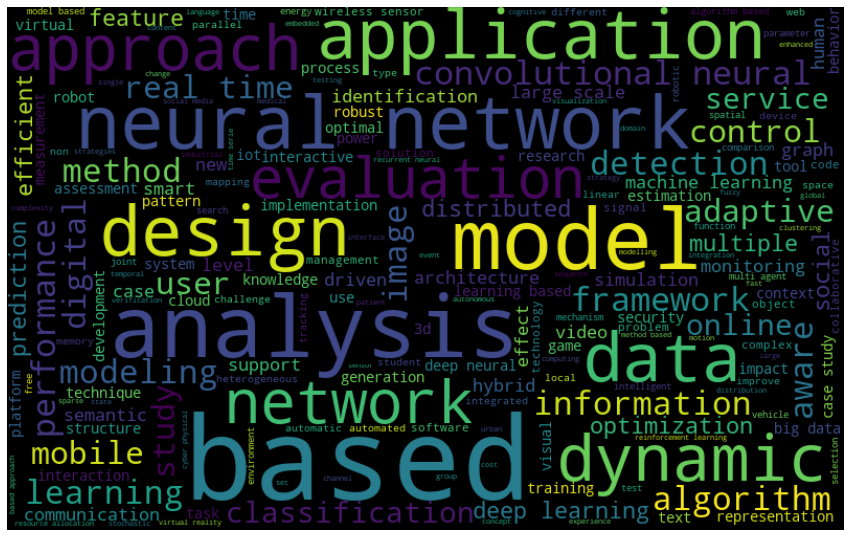

In [8]:
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [ ]:
# On va maintenant réaliser un histogramme avec le compte des mots les plus fréquents

Text(0.5, 1.0, 'Mots les plus courants')

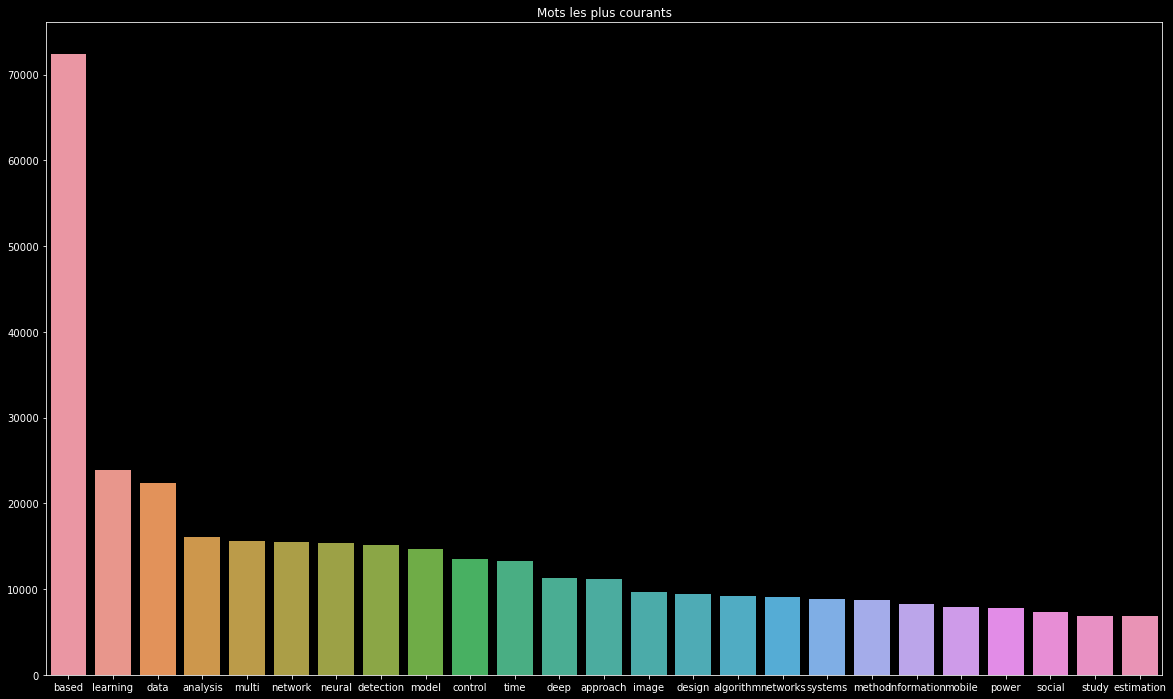

In [27]:
import seaborn as sns
from collections import Counter


# counts = Counter(all_words) : si on fait on aura la liste des lettres les plus courantes...
all_words_list = all_words.split()
counts = Counter(all_words_list)

common_words = [word[0] for word in counts.most_common(25)]
common_counts = [word[1] for word in counts.most_common(25)]

plt.style.use('dark_background')
plt.figure(figsize=(20,12))

sns.barplot(x=common_words,y=common_counts)
plt.title('Mots les plus courants')

In [68]:
matching = [s for s in article_titles.values() if 'based' in s] # charactere allemand
matching[0:10]

['integrating item based stereotypes recommender systems',
 'early diagnosis alzheimer disease based deep learning gwas',
 'effective line based slam adaptive tuning particles',
 'particle swarm programming based interactive content based image retrieval',
 'segmentation hypothesis based network performance evaluation high speed train users',
 'proper guidance image generation based saliency factor better transmission refinement image dehazing',
 'framework option buy strategy simple index futures trading based kelly criterion',
 'image coding based patch driven inpainting',
 'classifying illegal activities tor network based web textual contents',
 'pulse detection based mac protocol distributed wireless networks']

#### <span style="color:red"> 3ème nettoyage : détermination des mots clefs en utilisant la méthode tf-idf</span>

TF = term frequency = frequence d'un mot dans un document(phrase) donné. On peut créer une variante avec un choix binaire : 1 le mot apparait dans le document, 0 sinon


IDF = inverse term frequency = fréquence inverse de document: mesure l'importance du terme dans l'ensemble du corpus. Elle donne un poids important aux termes les moins fréquents. 
Plus elle est proche de 0 et plus le mot est commun et plus elle est élevé et plus le mot est rare.

Grosso modo, plus le tfidf est élevé et plus le terme est rare et plus il est faible et moins le mot est unique 

In [1]:
import pickle
with open ('dict_article_title.pkl','rb') as dict_article_titles:
    article_titles=pickle.load(dict_article_titles)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# TfidfVectorizer est équivalent à faire un CountVectorizer suivi d'un TfidTransformer

In [3]:
vectorizer = TfidfVectorizer(max_features=9000) # on prend les 9000 premiers mots les plus fréquents et on ignore les mots apparaissent dans moins de 1 % des documents
tf_idf_matrix = vectorizer.fit_transform(article_titles.values()) # apprend le vocabulaire et l'idf et retourne une matrice document termes

In [4]:
list(vectorizer.vocabulary_.keys())[:20] + ['...']

['decentralized',
 'optimal',
 'control',
 'framework',
 'connected',
 'automated',
 'vehicles',
 'urban',
 'intersections',
 'dynamic',
 'dimension',
 'optimized',
 'stage',
 'precoder',
 'design',
 'massive',
 'mimo',
 'systems',
 'limited',
 'feedback',
 '...']

In [5]:
names = vectorizer.get_feature_names()
names[0:20]

['14nm',
 '16nm',
 '1d',
 '1st',
 '21st',
 '22nd',
 '22nm',
 '23rd',
 '28nm',
 '2a',
 '2d',
 '2nd',
 '31st',
 '360',
 '3d',
 '3gpp',
 '3rd',
 '40nm',
 '4d',
 '4e']

In [6]:
corpus_index = [n for n in list(vectorizer.vocabulary_.keys())]
import pandas as pd
df = pd.DataFrame(tf_idf_matrix.todense(), columns=names)

In [7]:
df.head()

,14nm,16nm,1d,1st,21st,22nd,22nm,23rd,28nm,2a,...,zeros,zigbee,zika,zone,zones,zoom,zooming,zum,zur,zynq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.shape

(467051, 9000)

In [15]:
df.iloc[0].sort_values(ascending=False)[0:12]

intersections    0.454708
decentralized    0.357603
connected        0.345740
urban            0.327030
vehicles         0.316459
automated        0.289541
optimal          0.280234
dynamic          0.253187
framework        0.251065
control          0.221872
fabrication      0.000000
facial           0.000000
Name: 0, dtype: float64

In [21]:
df.iloc[1].sort_values(ascending=False)[0:12]

precoder     0.455175
dimension    0.372863
limited      0.342438
optimized    0.326431
stage        0.324272
massive      0.298454
feedback     0.282439
mimo         0.280098
design       0.203531
systems      0.189974
facebook     0.000000
faceted      0.000000
Name: 1, dtype: float64

In [38]:
for i in range(50):
    print(i,list(article_titles.items())[i])

0 ('conf/cdc/ZhangC18', 'decentralized optimal control framework connected automated vehicles urban intersections dynamic resequencing')
1 ('conf/milcom/KangLC18', 'dimension optimized stage precoder design massive mimo systems limited feedback')
2 ('conf/cidr/Termehchy17', 'reaching mutual understanding society humans database systems')
3 ('conf/svr/RochaP18', 'virtual reality historical review')
4 ('conf/medinfo/LiuZPCE17', 'correcting ontology errors simplifies visual complexity')
5 ('conf/hci/CardosoGMR18', 'applying implicit recommender preparation visits cultural heritage places')
6 ('conf/icinfa/DersarkissianJF18', 'control link robotic arm fuzzy logic')
7 ('conf/um/ALRossais18', 'integrating item based stereotypes recommender systems')
8 ('conf/closer/Ogunshile17', 'investigation use hybrid solar power cloud service solutions for7 computing')
9 ('conf/adc/SohailHCT18', 'location aware group preference queries social networks')
10 ('conf/ijcai/PanHZJS19', 'early diagnosis alzhei

In [22]:
df.iloc[8].sort_values(ascending=False)[0:12]

solar            0.420459
solutions        0.392594
investigation    0.375240
use              0.320256
service          0.304957
hybrid           0.297014
computing        0.293604
cloud            0.287247
power            0.275290
zynq             0.000000
fabricated       0.000000
face             0.000000
Name: 8, dtype: float64

In [40]:
df.iloc[49].sort_values(ascending=False)[0:12]

eine           0.754638
stakeholder    0.656141
zynq           0.000000
face           0.000000
facets         0.000000
faceted        0.000000
facet          0.000000
faces          0.000000
facebook       0.000000
fabrics        0.000000
facilitate     0.000000
fabrication    0.000000
Name: 49, dtype: float64

In [41]:
df.iloc[46].sort_values(ascending=False)[0:12]

junctions    0.507861
corner       0.446925
abnormal     0.405392
behaviour    0.361196
detector     0.358860
traffic      0.281278
detection    0.199081
facets       0.000000
faceted      0.000000
facet        0.000000
faces        0.000000
zynq         0.000000
Name: 46, dtype: float64

In [ ]:
################################ Fin de pas regarder après 

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000) # on prend les 5000 premiers mots les plus fréquents
tf_idf_matrix = vectorizer.fit_transform(train_corpus) # apprend le vocabulaire et l'idf et retourne une matrice document termes

In [ ]:
tf_idf_matrix

In [ ]:
names = vectorizer.get_feature_names()
data = tf_idf_matrix.toarray().tolist()

In [ ]:
names[0:20]

In [ ]:
# Create a dataframe with the results
df = pd.DataFrame(data, columns=names)

In [ ]:
df[0:2]

In [ ]:
# Print out the top N ranked words for each chapter
# This is done through selecting each row/dataset — due to our earlier choices these represent different chapters, and selecting the N highest ranked columns before printing them.

In [ ]:
N = 10;
for i in df.iterrows():
    print(i[1].sort_values(ascending=False)[:N])

In [ ]:
cv=CountVectorizer() # on ignore tous les mots qui apparaissent dans 85% des documents
word_count_vector = cv.fit_transform(list(article_titles.values())[0:20])

In [ ]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

In [ ]:
print(cv.get_feature_names()) # affiche l'ensemble de tous les mots utilisés toutes phrases confondues

In [ ]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 

In [ ]:
df_idf.sort_values(by=['idf_weights'])
# On constate que 3d est le mot le plus fréquent

In [ ]:
feature_names=cv.get_feature_names()

In [ ]:
tf_idf_vector=tfidf_transformer.transform(cv.transform([list(article_titles.values())][0]))

In [ ]:
tf_idf_vector[0]

In [ ]:
a=list(cv.vocabulary_.keys())

In [ ]:
b=list(cv.vocabulary_.keys())

In [ ]:
list(set(a)^set(b))

NEXT STEP : regarder comment éviter encore certaines erreurs (ex: 'themultitask' dans la 1ère valeur du dict) ??) + voir les oublies de certains caractères spéciaux + optimisation de la suppression d'autres mots inutiles

#### <span style="color:orange"> Test sur un échantillion</span>

In [ ]:
train_index = round(len(publication)*70/100)

In [ ]:
train_set = dict(list(article_titles.items())[:train_index])
test_set = dict(list(article_titles.items())[train_index:])

In [ ]:
dict(list(train_set.items())[0:20])

In [ ]:
dict(list(test_set.items())[0:20])

In [ ]:
train_corpus = list(train_set.values())
train_corpus[0:20]